In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast, os
import bambi as bmb
import pymc as pm
import arviz as az
import scipy.stats as stat
from collections import Counter

# Function to clean the data files

#### For each data file this function does the following:
1. Drops irrelevant columns
2. Computes accuracies (accurate if all correct keys pressed on the first try)
3. Label Node types: Boundary vs non boundary
4. Label transition types: Cross cluster or within cluster
4. Label other relevant conditions like walk length, number of keypresses, etc. 

In [2]:
def clean_data(filename):
    # print(filename)

    try:
        data = pd.read_csv('data/' + filename)

        # Drop instruction rows by dropping rows with missing data in column: 'blocks.thisRepN'
        data = data.dropna(subset=['blocks.thisRepN']).reset_index(drop=True)

        if len(data) < 1400:
            raise TypeError('Incomplete Data')

        #Compute accuracy as True if number of response values are the same as number of stim values
        # print(data['stim'])
        data['accuracy'] = [True if (len(ast.literal_eval(data['stim'][i])) == len(ast.literal_eval(data['key_resp.rt'][i]))) else False for i in range(len(data))]


        data['node_type'] = ['Boundary' if data['node idx'][i] in [0, 4, 5, 9, 10, 14] else 'Non Boundary' for i in range(len(data))]

        data['rt'] = [np.mean(ast.literal_eval(data['key_resp.rt'][i])) if data['accuracy'][i] else np.NaN for i in range(len(data))]
        data['transition_type'] = ['cross cluster' if (data['node_type'] == 'Boundary')[i] & (data['node_type'].shift() == 'Boundary')[i] else 'within cluster' for i in range(len(data))]

        if data['participant'][0]%4 == 0:
            data['walk_length'] = 0
        elif data['participant'][0]%4 == 1:
            data['walk_length'] = 3
        elif data['participant'][0]%4 == 2:
            data['walk_length'] = 6
        else:
            data['walk_length'] = 1400

        data['trial'] = np.arange(len(data))
        
        #Count the lag to indicate when the same stimulus was seen previously. Lag = 1 means the previous trial had the same stimulus.
        lag_counter_dict = Counter()
        lag = []

        for s in data['stim']:
            lag.append(lag_counter_dict[s])
            lag_counter_dict.update(lag_counter_dict.keys())
            lag_counter_dict[s] = 1
            # print(lag_counter_dict)
        data['lag'] = lag
        
    except:
        return None
    data['num_keypress'] = [len(ast.literal_eval(data['stim'][i])) for i in range(len(data))]

    return data[['participant', 'trial', 'blocks.thisRepN', 'accuracy', 'walk_length', 'node_type', 'transition_type', 'rt', 'stim', 'num_keypress', 'lag']]


# Read the data files

In [3]:
data_files = []
for f in os.listdir('data/'):
    if (f.startswith('3') & f.endswith('csv')):
        data_files.append(f)

# Clean the data files into a single large dataframe

1. Label Trials, conditions, etc. 
2. Combine relevant columns of extracted data files 
3. Specify outliers and remove them


In [4]:
df_clean = pd.concat([clean_data(f) for f in data_files]).reset_index(drop = True)
df_clean['reset'] = 'False'
df_clean.loc[df_clean['trial'].values%(df_clean['walk_length'].values+1) == 0, 'reset'] = 'True'



df_clean_rt_outlier = df_clean[np.abs(stat.zscore(df_clean['rt'], nan_policy='omit')) < 3]
df_clean_rt_outlier['node_transition_type'] = df_clean_rt_outlier['node_type'] + ' ' + df_clean_rt_outlier['transition_type']

# df_clean_participant = df_clean_rt_outlier.groupby(['participant', 'blocks.thisRepN', 'walk_length', 'node_type', 'transition_type', 'num_keypress']).median().reset_index()

df_clean_rt_outlier['walk_length'] = df_clean_rt_outlier.walk_length.astype('str')
df_clean_rt_outlier['num_keypress'] = df_clean_rt_outlier['num_keypress'].astype(str)



# Plot Accuracies

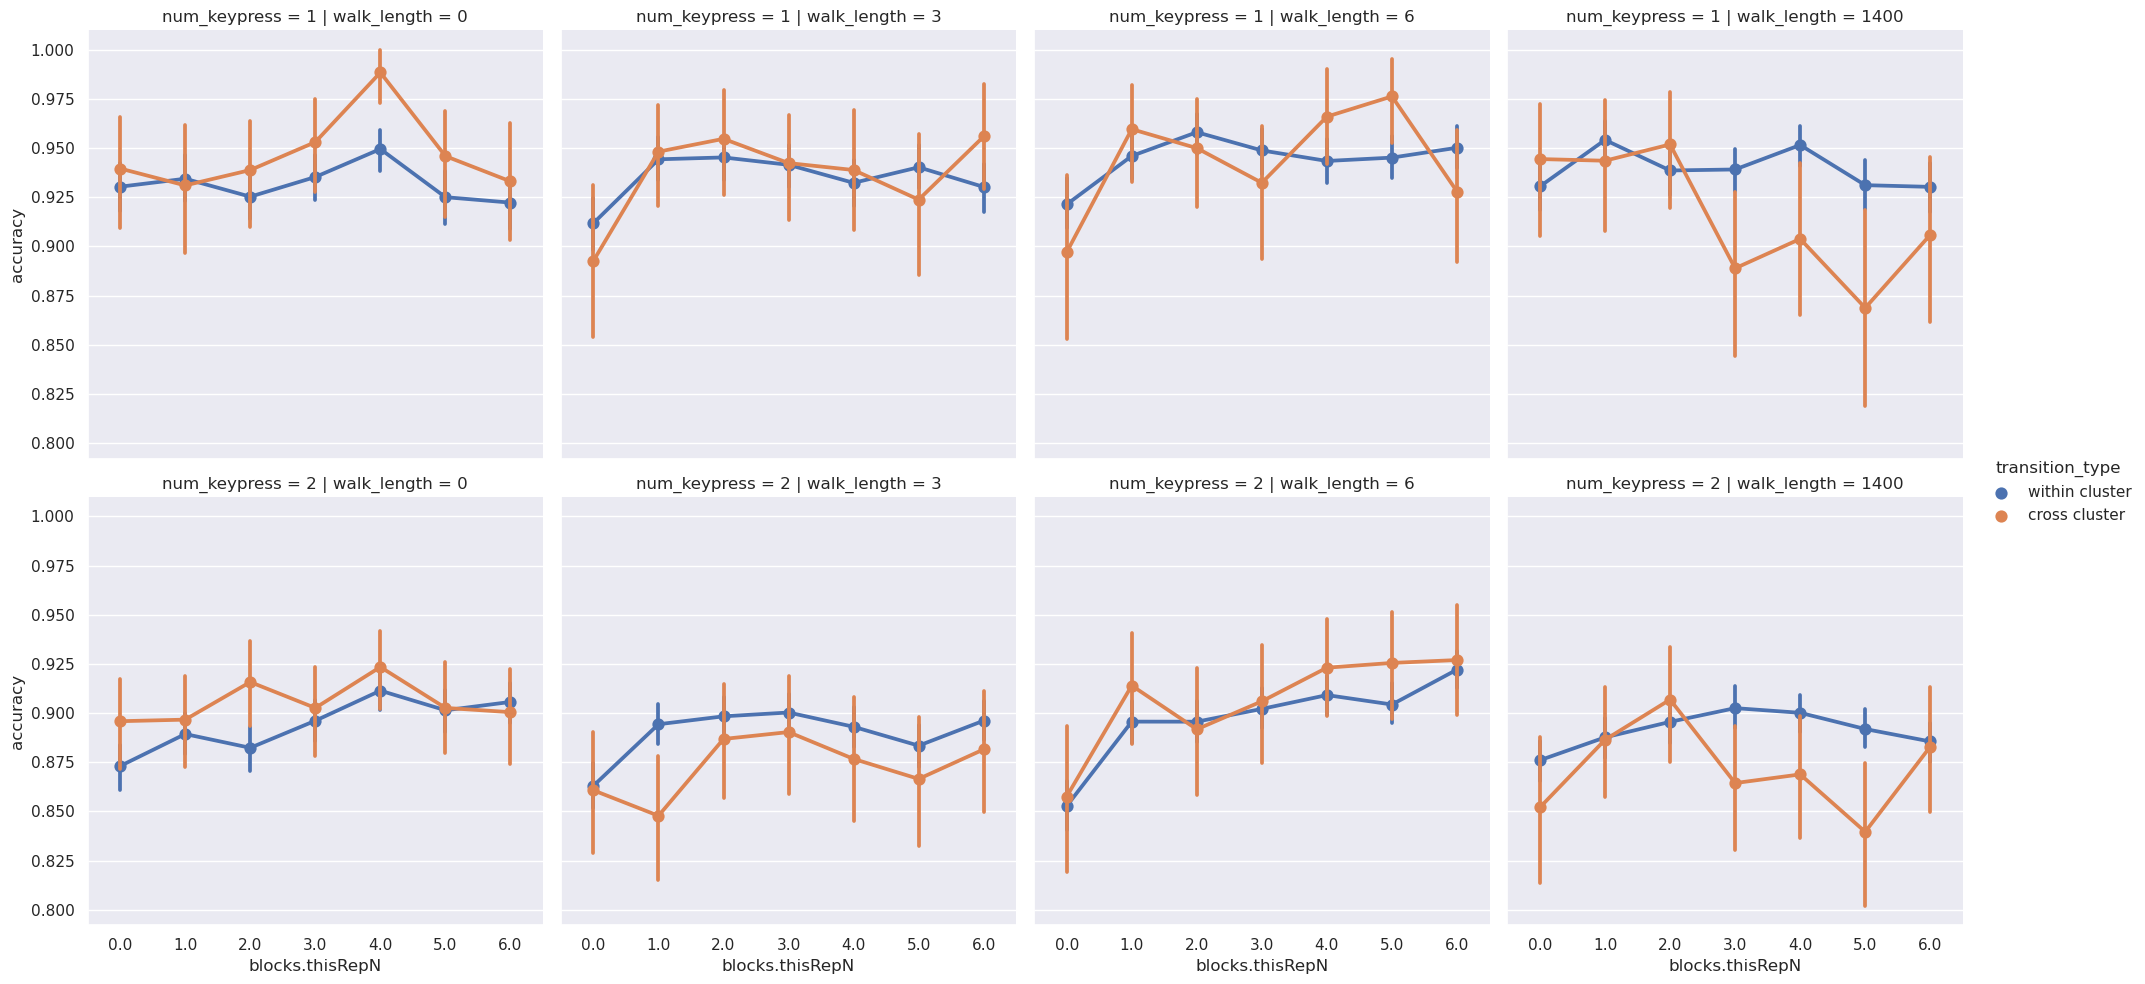

In [33]:
sns.set_context('paper')
sns.set_theme()
sns.catplot(y = 'accuracy', 
            x = 'blocks.thisRepN', col = 'walk_length', hue = 'transition_type', row = 'num_keypress',
            kind = 'point',
            data=df_clean)


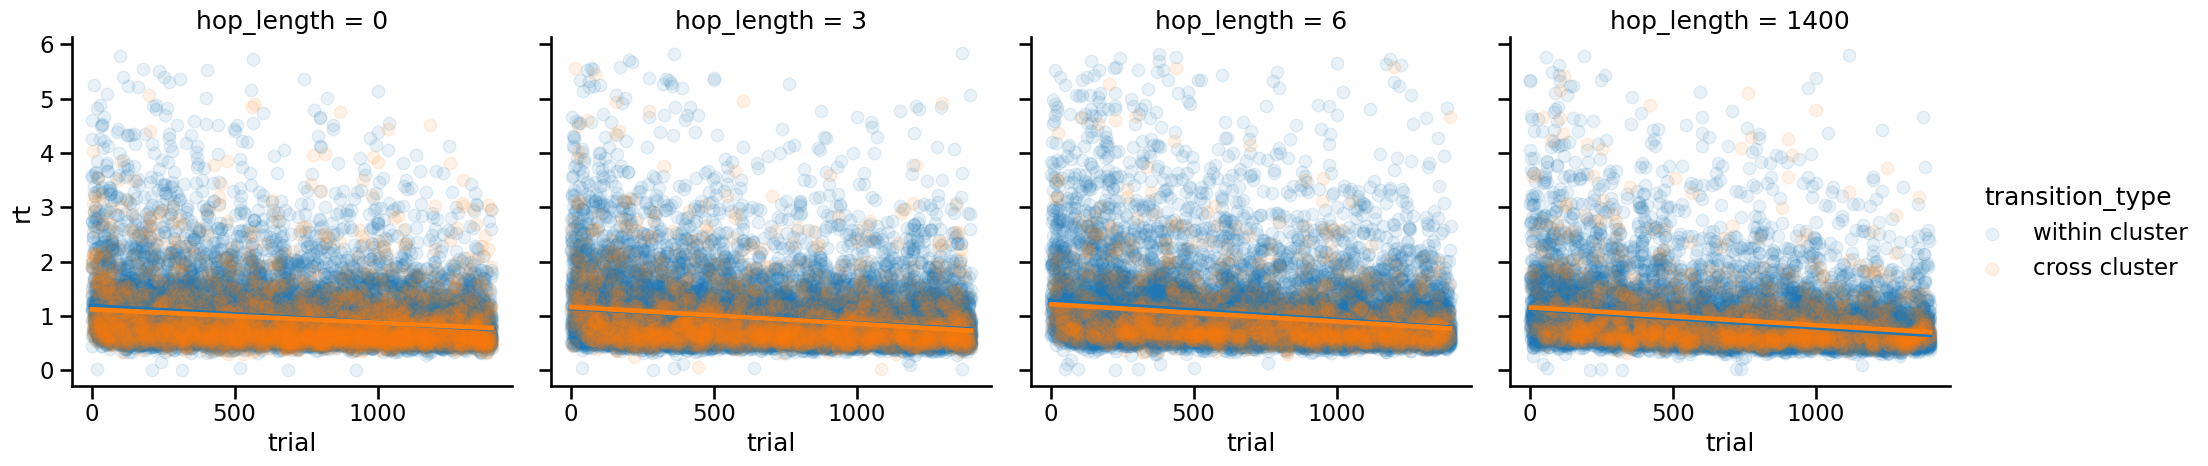

In [6]:
sns.lmplot(y = 'rt', 
            x = 'trial', col = 'walk_length', hue = 'transition_type',
            data=df_clean_rt_outlier, scatter_kws={'alpha': 0.1})


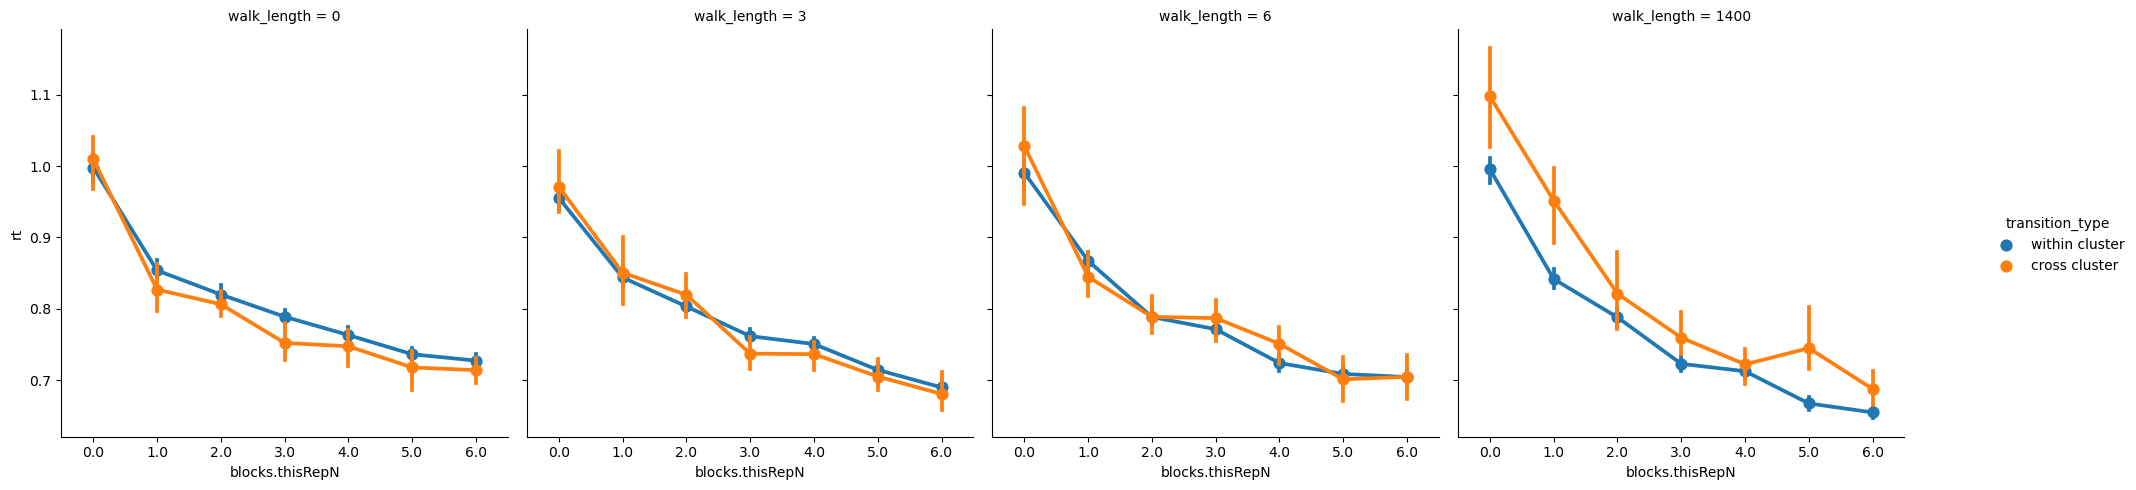

In [266]:
sns.catplot(y = 'rt', 
            x = 'blocks.thisRepN', col = 'walk_length', hue = 'transition_type',
            kind = 'point', estimator='median', margin_titles=True,
            data=df_clean_rt_outlier)


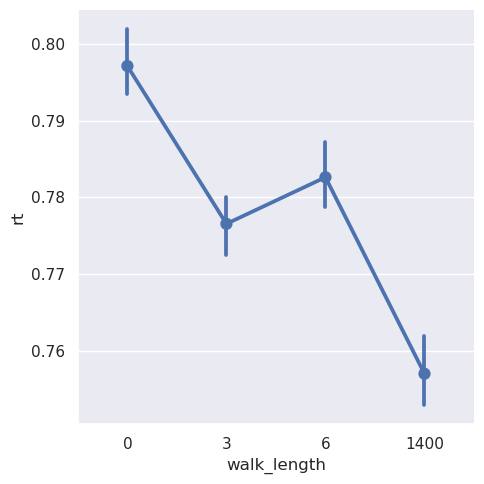

In [34]:
sns.catplot(y = 'rt', 
             x = 'walk_length', 
            row_order=['Non Boundary', 'Boundary'], margin_titles=True,
            kind = 'point', estimator='median',
            data=df_clean_rt_outlier)


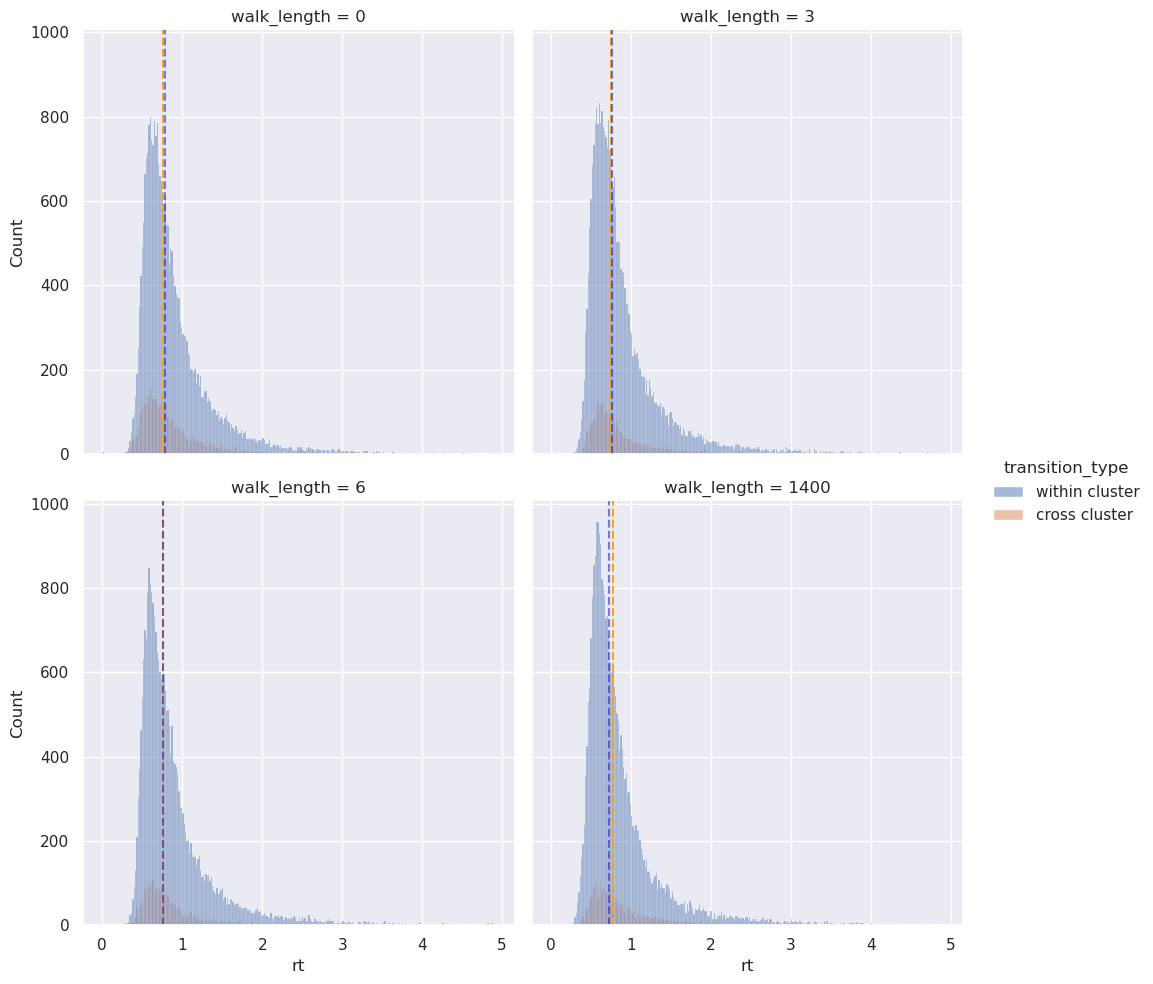

In [36]:
block_cutoff = 0
g = sns.displot(x = 'rt', hue='transition_type', col='walk_length', 
             col_wrap=2, 
             data = df_clean_rt_outlier.loc[df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff])
walk_lengths = [0, 3, 6, 1400]
for i in range(4):
    g.axes[i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['transition_type'] == 'cross cluster') & (df_clean_rt_outlier['walk_length'] == str(walk_lengths[i]))), 'rt']), 
                      c = 'orange', ls = '--', alpha = 1)
    
    g.axes[i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['transition_type'] == 'within cluster') & (df_clean_rt_outlier['walk_length'] == str(walk_lengths[i]))), 'rt']), 
                      c = 'blue', ls = '--', alpha = 0.5)

    # g.axes[0][i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['node_type'] == 'Boundary') & (df_clean_rt_outlier['walk_length'] == walk_lengths[i])), 'rt']), c = 'orange', ls = '--')
    # g.axes[0][i].axvline(np.nanmedian(df_clean_rt_outlier.loc[((df_clean_rt_outlier['blocks.thisRepN'] > block_cutoff) & (df_clean_rt_outlier['node_type'] == 'Non Boundary') & (df_clean_rt_outlier['walk_length'] == walk_lengths[i])), 'rt']), c = 'blue', ls = '--')


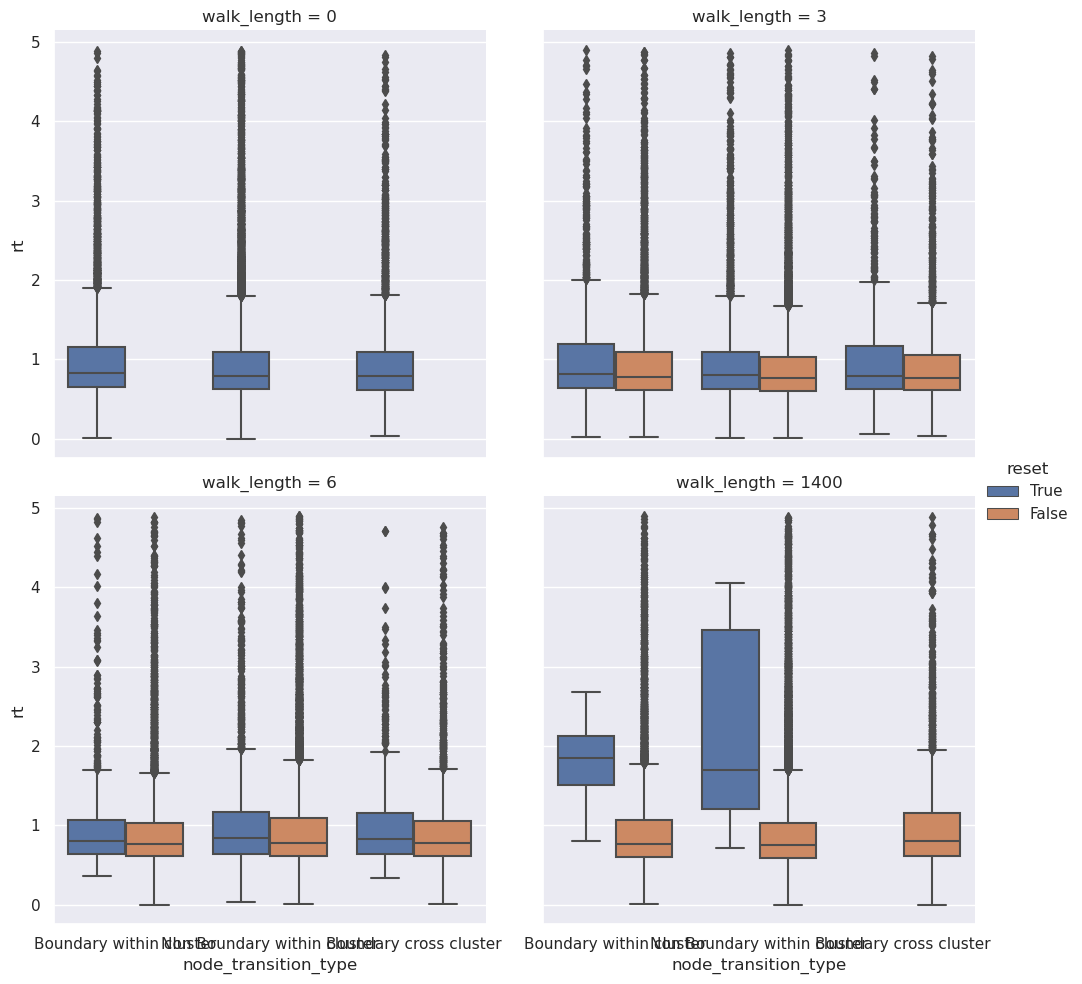

In [21]:
sns.catplot(y = 'rt', 
            hue = 'reset', x = 'node_transition_type', col = 'walk_length', 
            # row_order=['Non Boundary', 'Boundary'], margin_titles=True,
            kind = 'box', estimator='median', col_wrap=2,
            data=df_clean_rt_outlier)


In [59]:
df_clean_rt_outlier

,participant,trial,blocks.thisRepN,accuracy,walk_length,node_type,transition_type,rt,stim,num_keypress,lag,reset,node_transition_type
0,3000.0,0,0.0,True,0,Boundary,within cluster,1.367459,"('l', 'space')",2,0,True,Boundary within cluster
2,3000.0,2,0.0,True,0,Boundary,within cluster,1.377622,"('j', 'space')",2,0,True,Boundary within cluster
3,3000.0,3,0.0,True,0,Non Boundary,within cluster,1.171814,"('j', 'k')",2,0,True,Non Boundary within cluster
4,3000.0,4,0.0,True,0,Boundary,within cluster,1.230127,"('l', 'space')",2,4,True,Boundary within cluster
5,3000.0,5,0.0,True,0,Boundary,cross cluster,0.726496,"('l', 'space')",2,1,True,Boundary cross cluster
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158195,3127.0,1395,6.0,True,1400,Non Boundary,within cluster,0.553965,"('h',)",1,2,False,Non Boundary within cluster
158196,3127.0,1396,6.0,True,1400,Non Boundary,within cluster,0.407528,"('k',)",1,5,False,Non Boundary within cluster
158197,3127.0,1397,6.0,True,1400,Boundary,within cluster,0.553164,"('k', 'space')",2,5,False,Boundary within cluster
158198,3127.0,1398,6.0,True,1400,Boundary,cross cluster,0.605145,"('h', 'space')",2,106,False,Boundary cross cluster


In [63]:
df_clean_rt_outlier_median = df_clean_rt_outlier.loc[df_clean_rt_outlier['trial'] > 0].reset_index(drop=True).groupby(['participant', 'trial', 'transition_type', 'walk_length', 'reset']).mean(numeric_only=True).reset_index()
df_clean_rt_outlier_median_cross = df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'cross cluster'].reset_index(drop=True)
df_clean_rt_outlier_median_within = df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'within cluster'].reset_index(drop=True)
diff = df_clean_rt_outlier_median_cross.merge(df_clean_rt_outlier_median_within, on = ['participant', 'blocks.thisRepN', 'walk_length'])
# df_clean_rt_outlier_median_diff['diff'] = df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'cross cluster', 'rt'].values - df_clean_rt_outlier_median.loc[df_clean_rt_outlier_median['transition_type'] == 'Non Boundary', 'rt'].values
diff['rt_diff'] = diff['rt_x'] - diff['rt_y']
diff

,participant,trial_x,transition_type_x,walk_length,reset_x,blocks.thisRepN,accuracy_x,rt_x,lag_x,trial_y,transition_type_y,reset_y,accuracy_y,rt_y,lag_y,rt_diff
0,3000.0,5,cross cluster,0,True,0.0,1.0,0.726496,1.0,2,within cluster,True,1.0,1.377622,0.0,-0.651126
1,3000.0,5,cross cluster,0,True,0.0,1.0,0.726496,1.0,3,within cluster,True,1.0,1.171814,0.0,-0.445318
2,3000.0,5,cross cluster,0,True,0.0,1.0,0.726496,1.0,4,within cluster,True,1.0,1.230127,4.0,-0.503631
3,3000.0,5,cross cluster,0,True,0.0,1.0,0.726496,1.0,6,within cluster,True,1.0,0.645334,0.0,0.081162
4,3000.0,5,cross cluster,0,True,0.0,1.0,0.726496,1.0,7,within cluster,True,1.0,1.000822,6.0,-0.274327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2705680,3127.0,1398,cross cluster,1400,False,6.0,1.0,0.605145,106.0,1393,within cluster,False,1.0,0.604379,3.0,0.000766
2705681,3127.0,1398,cross cluster,1400,False,6.0,1.0,0.605145,106.0,1395,within cluster,False,1.0,0.553965,2.0,0.051180
2705682,3127.0,1398,cross cluster,1400,False,6.0,1.0,0.605145,106.0,1396,within cluster,False,1.0,0.407528,5.0,0.197617
2705683,3127.0,1398,cross cluster,1400,False,6.0,1.0,0.605145,106.0,1397,within cluster,False,1.0,0.553164,5.0,0.051981


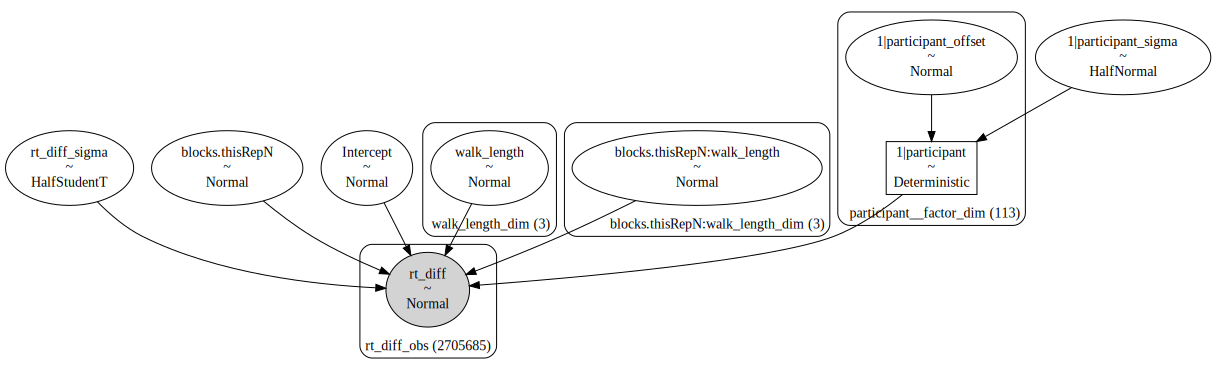

In [64]:
model = bmb.Model("rt_diff ~ blocks.thisRepN*walk_length +  (1|participant)", data = diff)
model.build()
model.graph()

In [65]:
model

       Formula: rt_diff ~ blocks.thisRepN*walk_length +  (1|participant)
        Family: gaussian
          Link: mu = identity
  Observations: 2705685
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0058, sigma: 4.0676)
            blocks.thisRepN ~ Normal(mu: 0.0, sigma: 0.938)
            walk_length ~ Normal(mu: [0. 0. 0.], sigma: [4.5163 4.345  4.5198])
            blocks.thisRepN:walk_length ~ Normal(mu: [0. 0. 0.], sigma: [1.208  1.1469 1.1879])
        
        Group-level effects
            1|participant ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 4.0676))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.7448)

# Fit a model or load a saved model. 

In [66]:
sample = model.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rt_diff_sigma, Intercept, blocks.thisRepN, walk_length, blocks.thisRepN:walk_length, 1|participant_sigma, 1|participant_offset]


ValueError: Not enough samples to build a trace.

In [2]:
# # #For loading a saved model
# sample = az.from_netcdf('results/bayesian_model_0_medianrt')

In [55]:
coords = {'walk_length_dim': ['1400', '6', '3'], 
          # 'walk_length:transition_type_dim':['1400, within cluster', '6, within cluster', '3, within cluster'],
          'blocks.thisRepN:walk_length_dim':['1400', '6', '3'],
         }

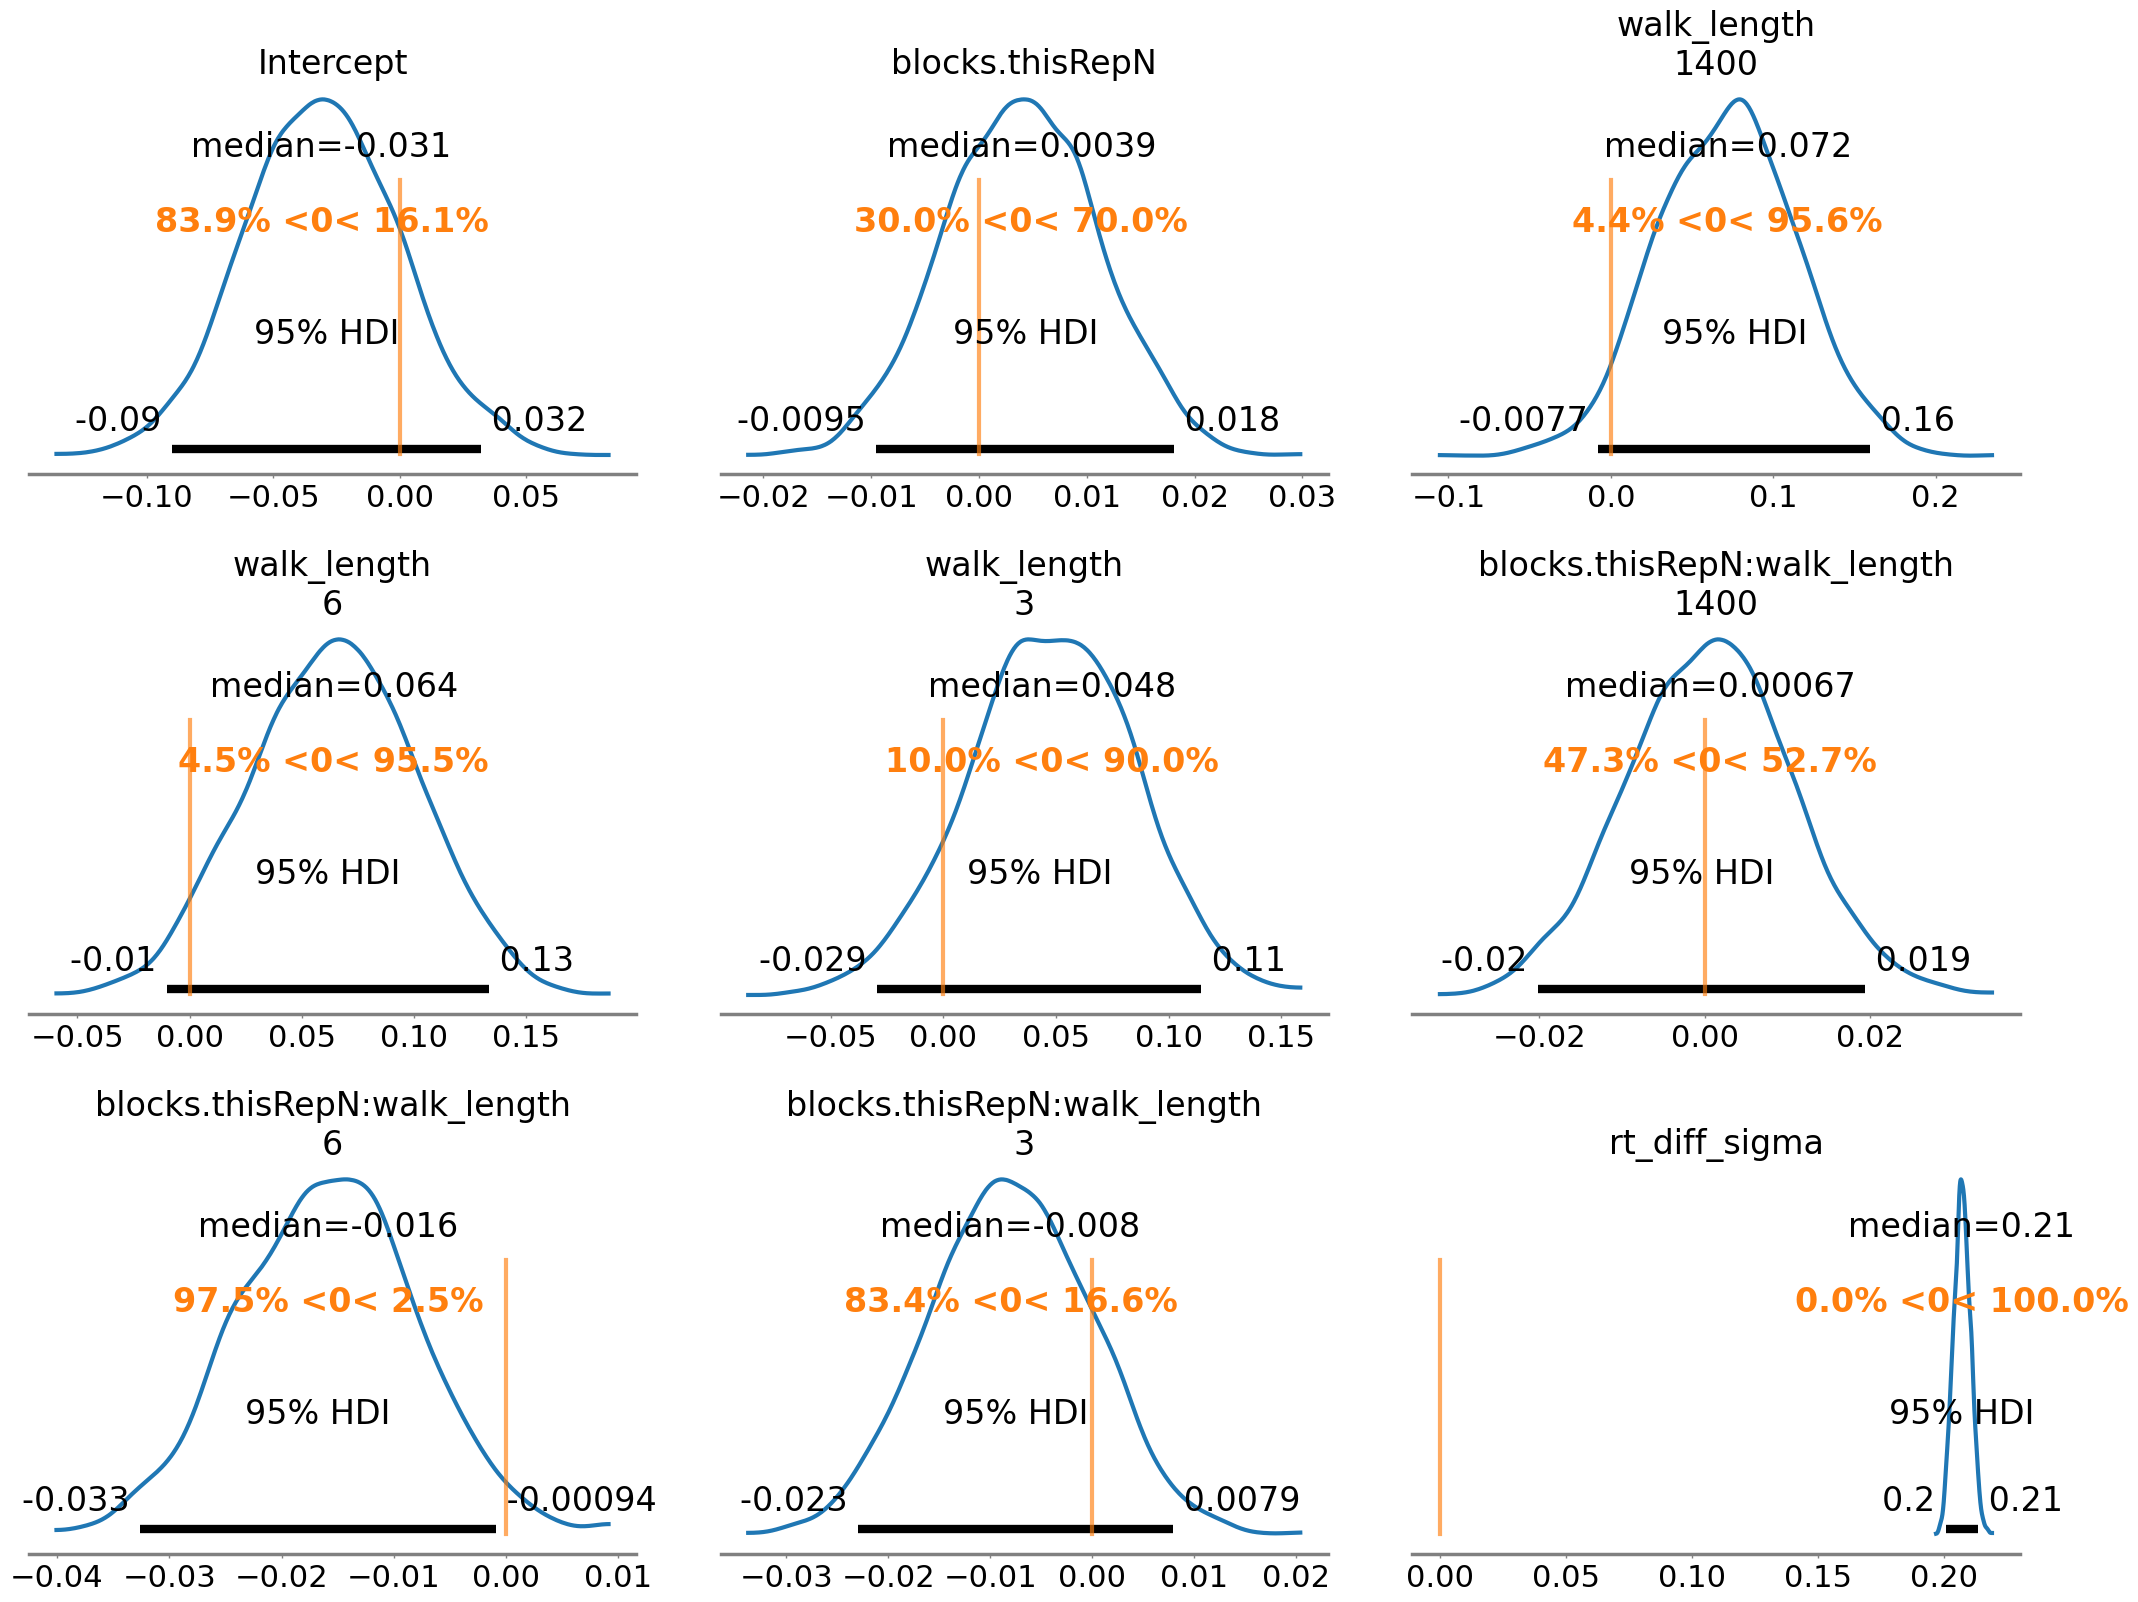

In [56]:
az.plot_posterior(sample, point_estimate='median', ref_val=0, hdi_prob=.95, var_names='~participant', filter_vars='like', coords = coords)
plt.tight_layout()
# plt.savefig('results/posteriors_bayesianmodel_0_params_medianrt.png', dpi = 600)

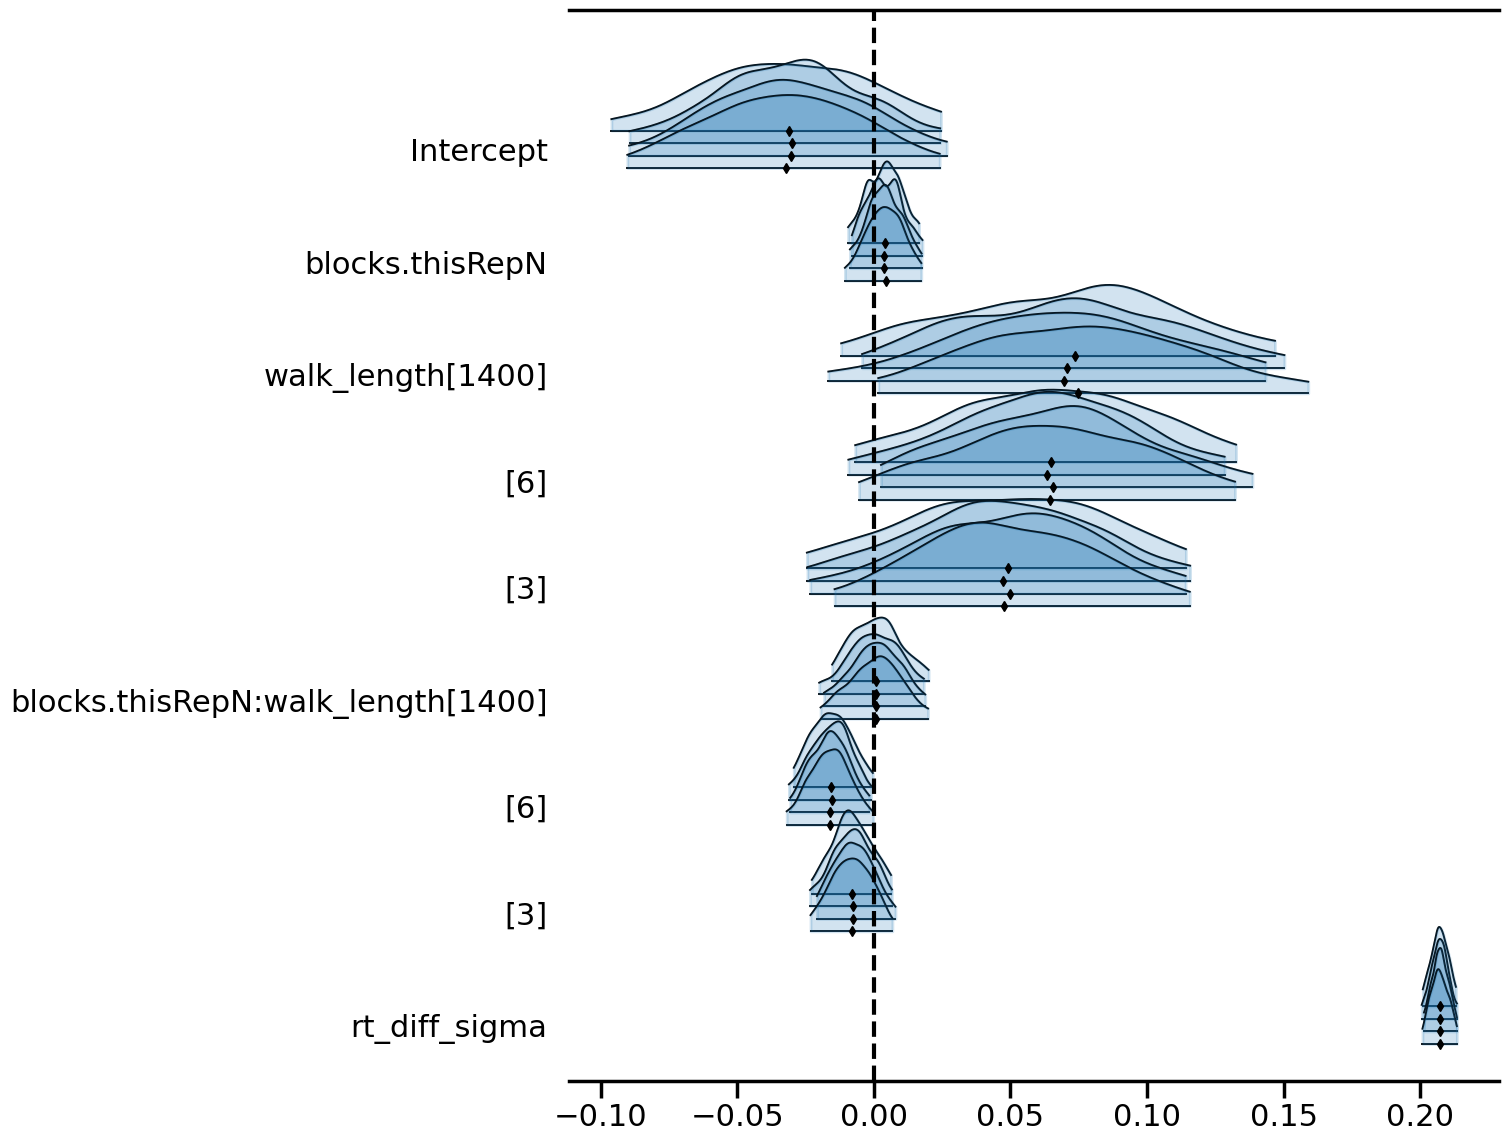

In [57]:
sns.set_context('poster')
g = az.plot_forest(sample, var_names='~participant', filter_vars='like', kind = 'ridgeplot', ridgeplot_quantiles = [0.5], ridgeplot_alpha=0.2, ridgeplot_overlap=1, 
              coords = coords, textsize=10)
g[0].axvline(0, ls = '--', color = 'black')
# plt.savefig('ridgeplot_bayesianmodel_0_params_medianrt.png', dpi = 600, bbox_inches = 'tight')

In [43]:
az.summary(sample, hdi_prob=.95, var_names = ['~participant'], filter_vars = 'like', coords=coords)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.725,0.034,0.656,0.790,0.001,0.001,1850.0,2413.0,1.0
reset[True],0.071,0.006,0.058,0.083,0.000,0.000,6623.0,2996.0,1.0
lag,0.002,0.000,0.001,0.003,0.000,0.000,8687.0,2787.0,1.0
blocks.thisRepN,-0.044,0.005,-0.053,-0.034,0.000,0.000,2744.0,2459.0,1.0
walk_length[1400],0.141,0.047,0.046,0.231,0.001,0.001,1875.0,2542.0,1.0
walk_length[6],0.133,0.046,0.044,0.227,0.001,0.001,1429.0,2038.0,1.0
walk_length[3],0.090,0.045,0.002,0.177,0.001,0.001,1617.0,2186.0,1.0
blocks.thisRepN:walk_length[1400],-0.011,0.007,-0.025,0.002,0.000,0.000,3278.0,2992.0,1.0
blocks.thisRepN:walk_length[6],-0.009,0.007,-0.022,0.004,0.000,0.000,2364.0,2699.0,1.0
blocks.thisRepN:walk_length[3],-0.004,0.007,-0.017,0.009,0.000,0.000,2497.0,2398.0,1.0


In [44]:
#Save model
az.to_netcdf(sample, 'results/bayesian_model_0_medianrt')

'results/bayesian_model_0_medianrt'

In [27]:
sample = az.from_netcdf('results/bayesian_model_0_rt')
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.834,0.038,0.767,0.909,0.001,0.001,710.0,1218.0,1.00
reset[True],0.047,0.005,0.038,0.056,0.000,0.000,4718.0,2619.0,1.00
lag,0.002,0.000,0.002,0.002,0.000,0.000,5155.0,2797.0,1.00
blocks.thisRepN,-0.060,0.006,-0.071,-0.050,0.000,0.000,633.0,1164.0,1.00
walk_length[1400],0.119,0.054,0.017,0.223,0.002,0.002,603.0,972.0,1.01
...,...,...,...,...,...,...,...,...,...
"num_keypress|participant[2, 3123.0]",0.322,0.032,0.264,0.379,0.000,0.000,5804.0,3187.0,1.00
"num_keypress|participant[2, 3124.0]",0.213,0.030,0.159,0.269,0.000,0.000,5695.0,2714.0,1.00
"num_keypress|participant[2, 3125.0]",0.316,0.029,0.260,0.369,0.000,0.000,5811.0,3258.0,1.00
"num_keypress|participant[2, 3126.0]",0.225,0.033,0.164,0.287,0.000,0.000,4981.0,2736.0,1.00


# Power Analyses

In [240]:
n_participants = 100
walk_lengths = np.array(['0', '1400'])
walk_lengths = np.array(['1400'])

transition_type = np.array(['within', 'across'])


walk_lengths_onehot = np.identity(len(walk_lengths))
walk_lengths_onehot = np.array([1, 0])

transition_type_onehot = np.identity(len(transition_type))

In [254]:
a = np.array([0.1, 0]) 
b = np.array([[0.1, 0.15]])
c = 10*np.mean(b)
d = 2*np.mean(b)

In [255]:
n_participants = 30
num_experiments = 100
median_rt_across = np.zeros((num_experiments, n_participants))
median_rt_within = np.zeros((num_experiments, n_participants))
for experiment in range(num_experiments):
    for participant in range(n_participants):
        rt_within = np.array([np.dot(transition_type_onehot[0], b.T) + np.random.exponential(c) + np.random.normal(0, d) for _ in range(840)])
        rt_across = np.array([np.dot(transition_type_onehot[1], b.T) + np.random.exponential(c) + np.random.normal(0, d) for _ in range(1400-840)])
        median_rt_within[experiment][participant] = np.median(rt_within)
        median_rt_across[experiment][participant] = np.median(rt_across)



In [256]:
power_df = pd.DataFrame({'rt' : np.ravel(median_rt_within) - np.ravel(median_rt_across),
                         'participant': np.tile(np.arange(n_participants), num_experiments),
                         'experiments': np.repeat(np.arange(num_experiments), n_participants)
                         },
                        )
power = np.mean(power_df.rt < 0)
power

0.7723333333333333

In [257]:
power_experiment = power_df.groupby(['experiments']).median().reset_index()
np.mean(power_experiment.rt < 0)

1.0

0.94